Importing the Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline 

In [2]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

[nltk_data] Downloading package stopwords to C:\Users\DRISHTI
[nltk_data]     DHINGRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Importing the dataset
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df.tail()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,"Director: Russell Crowe\nCast: Russell Crowe, ...",unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,"Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...",romantic,https://en.wikipedia.org/wiki/%C4%B0stanbul_K%...,The writer Orhan Şahin returns to İstanbul aft...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Cleaning the Data

In [5]:
df['Genre']=df['Genre'].replace('unknown',np.nan)
df=df.dropna(axis=0, subset=['Genre'])
print(df.tail())

       Release Year               Title Origin/Ethnicity         Director  \
34877          2013     Particle (film)          Turkish    Erdem Tepegöz   
34882          2017  Çalgı Çengi İkimiz          Turkish   Selçuk Aydemir   
34883          2017        Olanlar Oldu          Turkish      Hakan Algül   
34884          2017    Non-Transferable          Turkish  Brendan Bradley   
34885          2017  İstanbul Kırmızısı          Turkish   Ferzan Özpetek   

                                                    Cast            Genre  \
34877  Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...       drama film   
34882                          Ahmet Kural, Murat Cemcir           comedy   
34883              Ata Demirer, Tuvana Türkay, Ülkü Duru           comedy   
34884  YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...  romantic comedy   
34885  Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...         romantic   

                                               Wiki Page  \
34877      htt

In [6]:
print(df.shape)
print(len(df))
a=df['Genre'].value_counts()[:20]
b=a.keys().tolist()
print(b)
df=df[df.Genre.isin(b)]
df=df.reset_index(drop=True)

(28803, 8)
28803
['drama', 'comedy', 'horror', 'action', 'thriller', 'romance', 'western', 'crime', 'adventure', 'musical', 'crime drama', 'romantic comedy', 'science fiction', 'film noir', 'mystery', 'war', 'animation', 'comedy, drama', 'sci-fi', 'family']


<AxesSubplot:xlabel='Count', ylabel='Genre'>

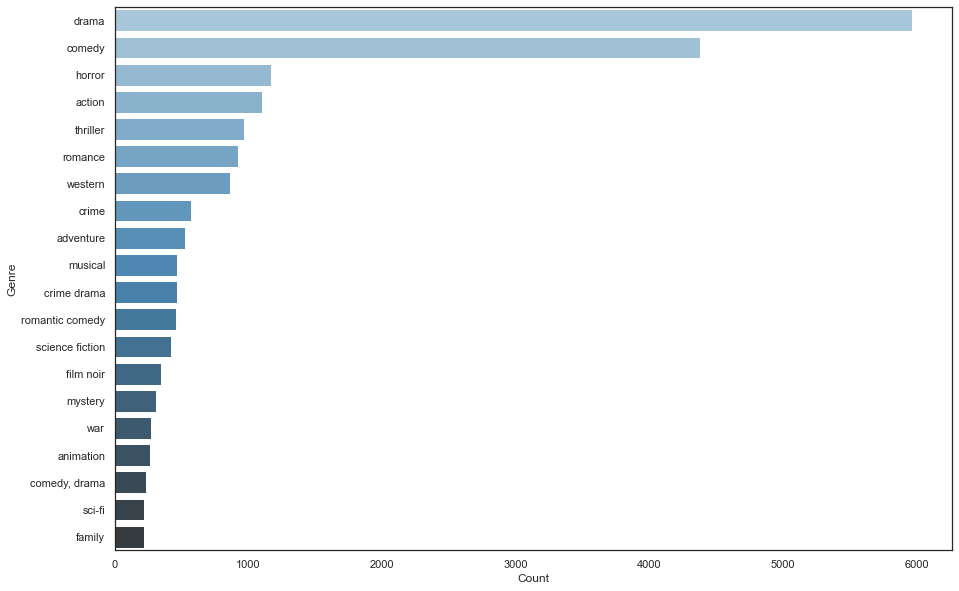

In [7]:
sns.set(style="white")
genre_to_count=pd.DataFrame({'Genre':a.index, 'Count':a.values})
plt.figure(figsize=(15,10))
sns.barplot(y="Genre", x="Count", data=genre_to_count,palette="Blues_d")

In [13]:
def plotToWords(raw_plot):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_plot)
    lower_case = letters_only.lower()
    words = lower_case.split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

def preprocess(dataframe):
    clean_train_reviews = []
    for i in range(0,len(dataframe)):
        clean_train_reviews.append(plotToWords(dataframe.iloc[i]['Plot']))
    dataframe['Plot']=clean_train_reviews
    return dataframe

df=preprocess(df)
print(df["Plot"][:10])

0    film opens two bandits breaking railroad teleg...
1    film family move suburbs hoping quiet life thi...
2    heading baseball game nearby ballpark sports f...
3    plot black woman going dentist toothache given...
4    beautiful summer day father mother take daught...
5    thug accosts girl leaves workplace man rescues...
6    young couple decides elope caught midst romant...
7    white girl florence lawrence rejects proposal ...
8    prints first american film adaptation christma...
9    film opens town mexican border poker game goin...
Name: Plot, dtype: object


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=4000)
features = tfidf.fit_transform(df.Plot).toarray()
labels = df.Genre
features.shape

(20132, 4000)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [19]:
print(clf.predict(count_vect.transform(["In an interview with CBC Radio, UniversitÃ© de MontrÃ©al History Professor Dominique St. Arnaud tells Diane about her new book, Variations on the Idea of Happiness, which discusses her thesis that modern society's fixation on self-indulgence is indicative of its decline, predicting a collapse in the ""American Empire,"" of which Quebec is on the periphery. Several of Dominique and Diane's friends, mostly intellectual history professors at the university, prepare for a dinner later in the day, with the men at work in the kitchen while the women work out at the gym. As the dinner draws nearer, the men and women mainly talk about their sex lives, with the men being open about their adulteries, including RÃ©my, who is married to Louise. Most of the women in the circle of friends have had sex with RÃ©my, though he is not attractive, but they conceal this from Louise to spare her feelings. Louise has been to an orgy with RÃ©my, but believes he is generally faithful to her in Montreal. The friends are also accepting of their homosexual friend Claude, who speaks about pursuing men reckless of fear of STDs, while secretly being fearful of having one. During the dinner party, the friends listen to Dominique's theories about the decline of society, with Louise expressing skepticism. To retaliate against Louise, Dominique reveals she has had sex with RÃ©my and their friend Pierre, causing her to have an emotional meltdown. By morning, relationships have gone back to normal."])))

['drama']


C:\Users\DRISHTI DHINGRA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DRISHTI DHINGRA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

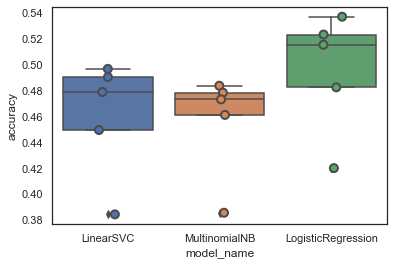

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [26]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.459963
LogisticRegression    0.495677
MultinomialNB         0.456386
Name: accuracy, dtype: float64